In [227]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, copy, os, shutil
from tqdm.notebook import tqdm
import seaborn as sns
from importlib import reload

import GridWorldHelpers as gwh
import GridWorldTests as gwt

Load and visualize baseline grid world, world with normal pond, world with overflow pond in terms of their  (mean **rewards**)

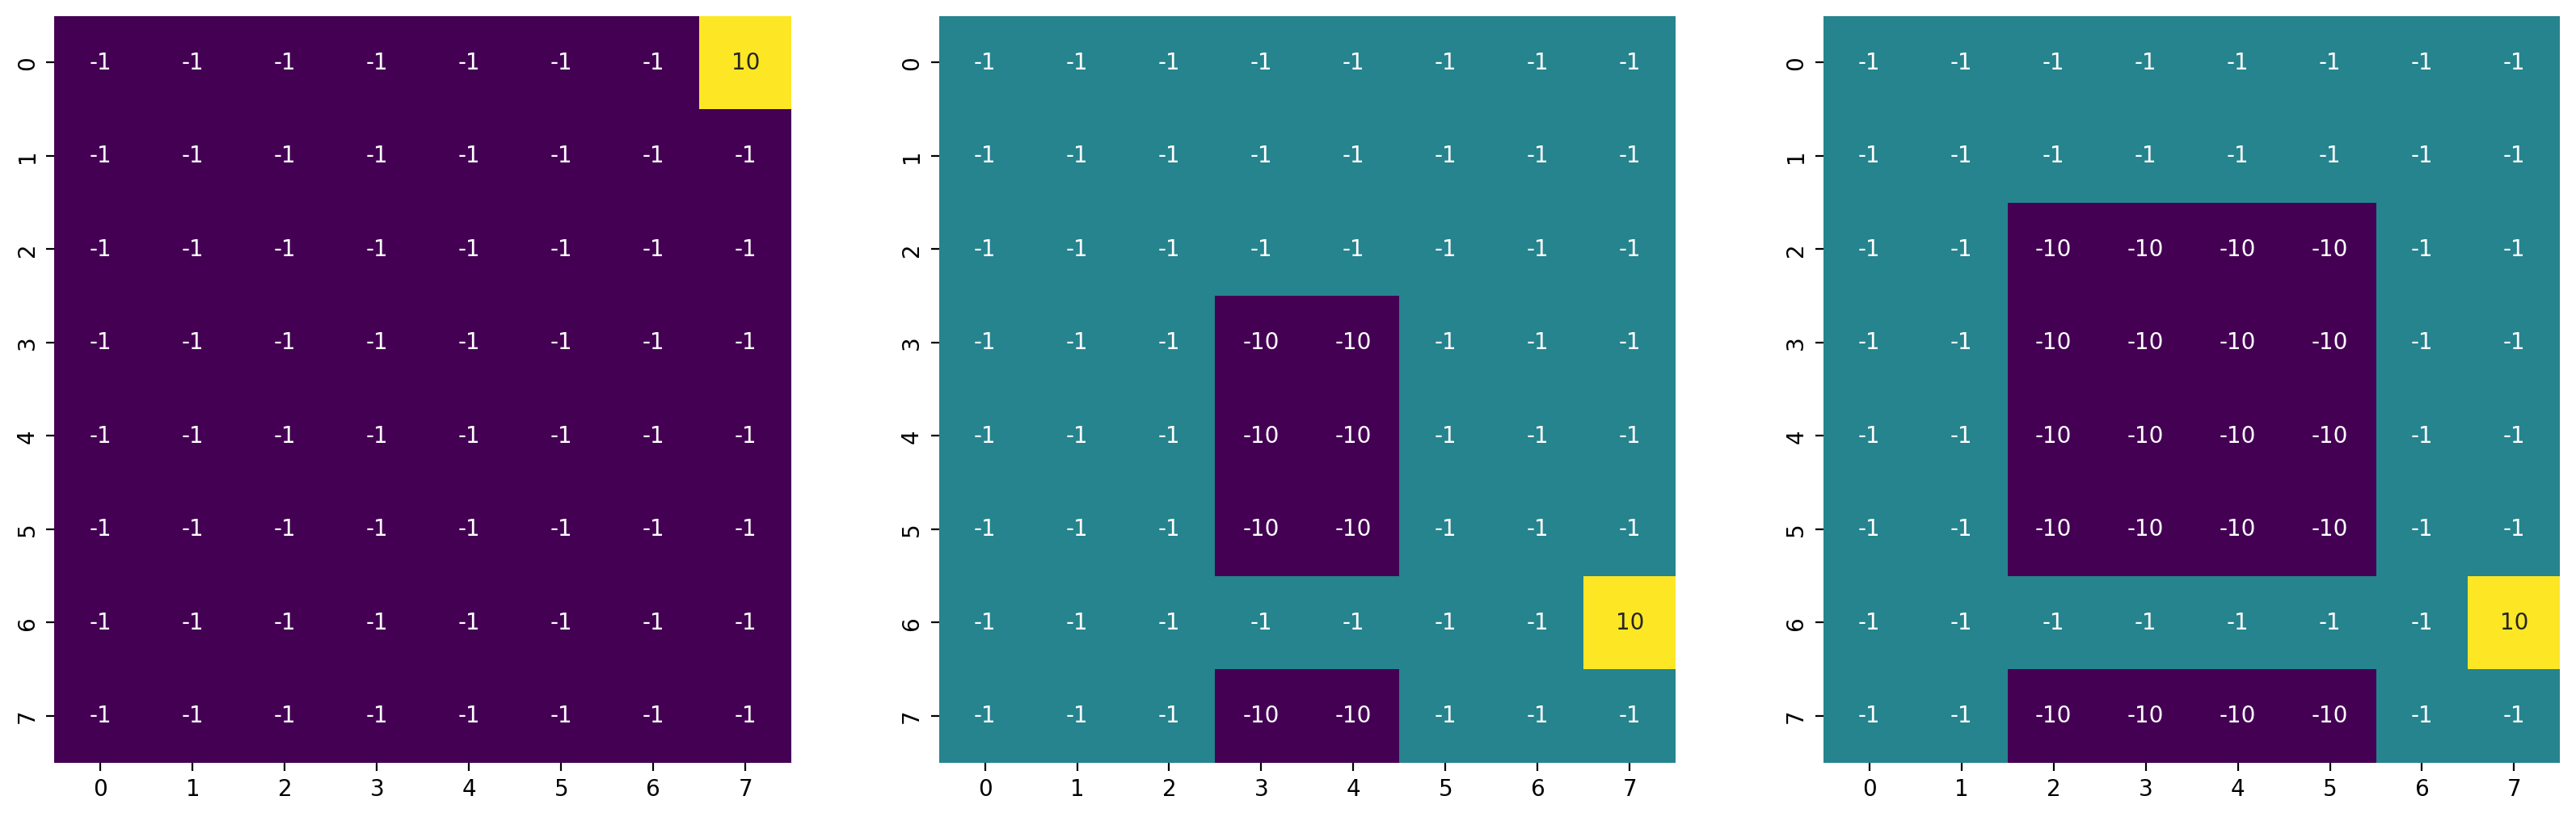

In [228]:
reload(gwh)
gw0, gw1, gw2 = gwh.build_grids(d=8, 
                               baseline_penalty = -1,
                               water_penalty = -10,
                               end_reward = 10)

fig, ax = plt.subplots(1, 3, dpi=200, figsize=(20, 6))
gwh.visualize_reward_grid(gw0, ax[0])
gwh.visualize_reward_grid(gw1, ax[1])
gwh.visualize_reward_grid(gw2, ax[2])

Obtain and visualize the colors grids for each of the grid worlds

In [ ]:
# make the color-grid for GridWorld1
gw0_colors = gwh.make_gw_colors(gw0) 
gw1_colors = gwh.make_gw_colors(gw1)
gw2_colors = gwh.make_gw_colors(gw2)

fig, ax = plt.subplots(1, 3, dpi=200, figsize=(20, 6))
gwh.visualize_reward_grid(gw0_colors, ax[0])
gwh.visualize_reward_grid(gw1_colors, ax[1])
gwh.visualize_reward_grid(gw2_colors, ax[2])

### Parameters and initialization

* **TODO** function which initializes agent location
* for now just setting all to 0.5

In [6]:
p_switch = 0.5 #water stochasticity
p_wind_i = 0.5 #probability of wind at each step
p_wind_j = 0.5
ce = 0 #start at current environment 1

## Procedure

At each time $t$

1. Run ``gwh.get_environment()`` with parameter ``p_overflow`` to determine if pond has overflowed or not (**water stochasticity**).

   * Note: for baseline environment, there is no pond and p is set to 0 
   * I made it so that overflow is markovian with $p(new|current)=p$ and $p(current|current)=p$. That ways there's more of a MDP type thing to learn.

   
2. Using ``gwh.sync_color``, obtain color for current location and update True State

3. **TODO** Using some missing data function, determine agent's observed state

4. **Agent**: given observed state ``Ostate``, previous state and previous action, any relevant objects learned from the history, run ``Learner()`` to output an action ``a``

5. **System** given true state ``Tstate`` and action ``a``,

* generate next true $(x,y)$ (stochastic due to **wind**), **but** not yet updating color because environment might change (e.g., based on current green, you decide to go right but by the time you get there, your next location actually is flooded)
 


In [224]:
reload(gwh)

# set-up the possible environments
environments = {
                0: [gw0, gw0_colors], #baseline
                1: [gw1, gw2_colors],
                2: [gw2, gw2_colors] #flooding
               }

# pick current environment 
ce = gwh.get_environment(ce, p_switch, indices = np.array([1,2]))

In [225]:

# given pick, get the reward grid and the color grid to use for this step
gw = environments[ce][0]
gw_colors = environments[ce][1]

# we know current (x,y) from a previous step  - for now, pretend it is this
# get color from current environment
Tstate = np.array([1,1,np.nan]) #(x,y green) # true state
Tstate = gwh.sync_color(Tstate, gw_colors)

#TODO: missing data mechanism applied to determine observed state
Ostate = None

#TODO: learning algorithm to pick an action, for now pretend it's up
a = (0,1)

# Implement move but we don't know color this move will result in yet
# Also, possibly there is some wind blowing us off course
Tstate_new = gwh.true_move(Tstate, a, gw, gw_colors, p_wind_i, p_wind_j)

print(Tstate, Tstate_new)

[1. 1. 0.] [ 0.  0. nan]


### Missing data functions 


In [184]:
reload(gwt)
gwt.test_miss_mech()

All tests passed


In [195]:
reload(gwh)
theta_dict = {0: np.array([.1,.1,.1]), 1: np.array([0.0,0.0,0.0]), 2: np.array([.4,.4,.4])}
i_range = (3,5); j_range = (3,5)
thetas_in = np.array([.1,.1,.1])
thetas_out = np.array([0.0,0.0,0.0]) 

#Example calls to each
state = np.array([1,1,1])
gwh.MCAR(state,np.array([0 ,0,0]))
gwh.Mcolor(state,theta_dict)
gwh.Mfog(state, i_range = i_range, j_range = j_range, thetas_in = thetas_in, thetas_out = thetas_out)

array([1., 1., 1.])

### Taking actions

In [190]:
#reload(gwt)
#gwt.test_actions()

# 4/8/2024 Notes

In [ ]:
'''
# size of our setup:
1. |A| = 9
2. |S| \leq 8*8*3 = 192 (assuming d=8)

# missing data imputation mechanisms. Our wishlist is to learn
1. S_{t+1} | S_t, A_t # has size \leq 50 * 64 * 9, note the true sparsity.
2. S_{t+1,j} | S_t, A_t, S_{t+1,-j} # has size 3*64*9*64
    
    
# baselines
1. Just use the most recent fully-observed state as our current state.
2. Choose action completely at random and only learn from complete cases.
3. Treating any-missing as a separate state.
'''

# data structure for S_{t+1} | S_t, A_t (standard)
Trans_stan = {}

# data structure forb S_{t+1,j} | S_t, A_t, S_{t+1,-j} (mice)
Trans_mice = {"x" : {}, "y" : {}, "z" : {}}

'''
# can update above data structures, 
a) only fully-observed
b) if partially-observed, update entries corresponding to partially-observed and
   using imputations with some fractional updating 1/K 

Decision 1: could think about having a different transition matrix for each pathway
    (and sometimes flipping them to help correct wayward transition matrices) but this
    gets really costly and unscalable so we will update a SINGLE COMMON Tran_stan and
    Tran_mice with count update 1/K for each MI imputation. This means that we get
    +1 if full observed, larger additions of imputations agree more. THat also has a 
    'corrective' element by making it so a single bad imputation has less influence

Decision 2: the chains will evolve separately (so S_t's may differ for the same time step
    if there was missingness) but we will try randomly shuffling/mixing the chains at some 
    frequency to try to avoid paths that go off in bad directions. It may be that this proves
    unnecessary because the chains 'sync up' any time hit a completely observed state 
    [this was more of a concern when had separate transitions matrices for each] but we will
    still experiment with if it helps. Will probably require a "mix frequency" parameter for this

Decision 3: we will start with learning a single Q function (again with 1/K updates) and 
    policy that optimizes that single Q function, though policies still need to 'vote'
    on actions since we may different multiple imputed states and the policy may recommend
    different actions for those different imptued states

    Alternative would be to have a different Q function for each chain, different policies for each
    chain, and then the "max then average" vs "average then max" thing matters...but again,
    this quickly increases complexity by a lot so we will not start with this

    

*note that in partially-observed case, we will do voting-based action selection.
*we will update A COMMON Tran_stan and Trans_mice with update counter 1/K for each MI imputer, +1 for full obs.
*Try mixing of chains avs. "sync" up from complete states. Might need a mix-frequency parameter.
*note that mixing of chains could be somewhat similar effect to mixing of Q functions.
''''''

In [ ]:
'''
Q-update step:
Q(S_t^obs, S_t^miss(k), A_t) <- (current) + \frac{\alpha}{K}[R_{t+1} + \gamma \max_a Q(S_{t+1}^{obs}, S_{t+1}^(k), a) - current]

'''

$$Q(S_t^{obs}, S_t^{miss,(k)}, A_t) \leftarrow Q(S_t^{obs}, S_t^{miss,(k)}, A_t) + \frac{\alpha}{K}\left[R_{t+1} + \gamma \max_a Q(S_{t+1}^{obs}, S_{t+1}^{(k)}, a) - Q(S_t^{obs}, S_t^{miss,(k)}, A_t) \right]$$

In [226]:
# Environment set-up
environments = {
                0: [gw0, gw0_colors], #baseline
                1: [gw1, gw2_colors], #normal pond
                2: [gw2, gw2_colors] #flooding
               }

# Parameters to initialize
p_switch = 0.5 #flooding Markov chain parameter
p_wind_i = 0.5 #up-down wind frequency
p_wind_j = 0.5 #left-right wind frequency

# "current environment"
ce = 1 # starting environment

# which environments are we flipping through?
indices = np.array([1, 2]) # the two to be flipping between, if any. If just one, make first element 


# Objects to initialize
Trans_stan, Trans_mice, Q, policy  #TODO: initialization functions

# loop for each episode
for epi_idx in range(episodes):
    
    # initialize our FULLY-OBSERVED state at time 0
    Tstate #TODO: initialization fu nction
    
    # for each step of episode, i.e., until we hit the +10
    while true_state != terminal_state:
        
        # choose action based on voting-based ensemble (if necessary), 
        A = get_action(policy, states)  #TODO
        
        # simulate pond flooding vs. not flooding to change dynamics.
        ce = get_environment(ce, p_switch, indices)
        gw = environments[ce][0]
        gw_colors = environments[ce][1]

        # environment's true S_{t+1} 
        TState = true_move(Tstate, a=A,
                           gw = gw, gw_colors = gw_colors, 
                           p_wind_i = p_wind_i, p_wind_j = p_wind_j)


        # environment outputs reward R_{t+1}
        R = get_reward(gw)
        
        # environment outputs observed S_{t+1}^{obs}
        OState = get_ostate(Tstate, mechanism)  #TODO - implement flexible way of specifying miss data mech
        
        # make our imputations on S_{t+1}
        S_imp = get_imputations(Ostate, S_imp_old, A, 
                                Tstandard, Tmice, method)  
              #TODO - implement methods, including mix prob where necessary
        
        # update our Q functions, Trans_stan, Trans_mice #TODO - these updates
        Q = update_Q(S_imp, R, A, Q)
        policy = update_policy(Q)
        Trans_stan = update_Tstan(S_imp)
        Trans_mice = update_Tmice(S_imp)
        
        # set current imputed state as old imputed states for next step
        S_imp_old = S_imp
        

NameError: name 'Trans_stan' is not defined

# List of cases to possibly look at

Missing data mech
1. Basic MAR with all same probability
2. MAR under different \theta rates

Some things to think about
* Initializing transitions with 0 values vs positive values / with or without logical constraints
* Whether agent has access to logical constraints like "if I move right, I know it won't move me more than 2 steps" or not
* If agent knew the NMAR mechanism, could do MLE type stuff but we would only do this for comparison since more realistic scenario is agent does not know the missing data mechanism
* Whether to **increase pond penalty** in magnitude -20 or more

